## Imports

In [139]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Matplotlib  & Seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 2)
sns.set_style('ticks')
plt.style.use('seaborn-white')
mpl.rcParams['font.family'] = 'serif'

# Pandas and numpy
import pandas as pd
import numpy as np

# Normal distribution from scipy
from scipy.stats import norm

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [140]:
# run some files containing custom functions
%run -i '../scripts/helper_functions_1.py'
%run -i '../scripts/helper_functions_2.py'

## Load data

In [26]:
df = pd.read_pickle('../data/dollar_exchange.pkl')
df.head()

,Value
Date,
1975-01-02,0.7633
1975-01-03,0.7585
1975-01-06,0.7524
1975-01-07,0.7510
1975-01-08,0.7554


In [27]:
# Data shape
df.shape

(11347, 1)

## Resampling

We resample the data into weekly data

In [28]:
ts = df.resample('W').mean() 

In [29]:
# Drop missing value due to resampling
ts = ts.dropna() 

In [30]:
# Shape of data after resampling
ts.shape

(2342, 1)

In [31]:
# Rename columns
ts = ts.rename(columns = {'Value': 'y'})

## Lags

In [32]:
for i in range(1,8):
    ts['Lag_{}'.format(i)] = ts.y.shift(i)

ts = ts.dropna()

In [33]:
ts.head()

,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
Date,,,,,,,,
1975-02-23,0.73538,0.74142,0.74906,0.73902,0.74388,0.75546,0.75346,0.76090
1975-03-02,0.72578,0.73538,0.74142,0.74906,0.73902,0.74388,0.75546,0.75346
1975-03-09,0.72668,0.72578,0.73538,0.74142,0.74906,0.73902,0.74388,0.75546
1975-03-16,0.73212,0.72668,0.72578,0.73538,0.74142,0.74906,0.73902,0.74388
1975-03-23,0.72868,0.73212,0.72668,0.72578,0.73538,0.74142,0.74906,0.73902


In [34]:
ts.shape

(2335, 8)

## Feature Matrix and Target Variable
We separate the feature variables X from the target variable y.

In [35]:
X, y = ts.drop('y', axis = 1), ts.y

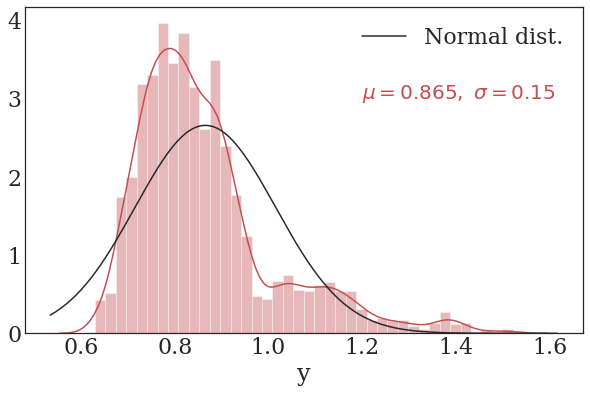

In [36]:
# Set figure size
plt.figure(figsize = (10,6))

# Mean and Standard deviation of the target variable
mu, sigma = y.mean(), y.std()

# Plot distribution
sns.distplot(y,  fit = norm, color = 'r')
plt.legend(['Normal dist.'],loc='best')
plt.text(1.2, 3, r'$\mu = {},~ \sigma = {}$'.format(str(round(mu,3)), str(round(sigma,3))),
         color = 'r',  fontsize=20)
plt.show()

The distribution is right skewed, therefore we will log transform it

## Log-transformation

In [42]:
# Log transformation of the target variable
logy =  np.log(y)

In [38]:
# Log transformation of the predictors
num_att = list(X.columns)
for col in num_att:
        X[col] = np.log(X[col])

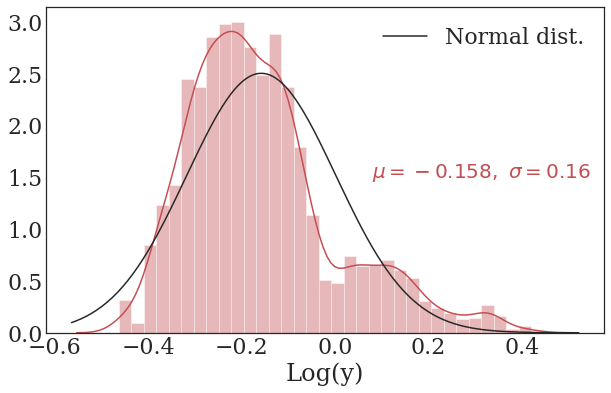

In [47]:
# Set figure size
plt.figure(figsize = (10,6))

# Mean and Standard deviation of the target variable
mu, sigma = logy.mean(), logy.std()

# Plot distribution
sns.distplot(logy,  fit = norm, color = 'r')
plt.xlabel('Log(y)')
plt.legend(['Normal dist.'],loc='best')
plt.text(0.08, 1.5, r'$\mu = {},~ \sigma = {}$'.format(str(round(mu,3)), str(round(sigma,3))),
         color = 'r',  fontsize=20)
plt.show()

## Create a Test Set

We reserve the last 365 observations as the test set and use the rest as the training set

In [89]:
test_size = len(X)-365

In [90]:
X_train, logy_train = X.iloc[:test_size], logy.iloc[:test_size]
X_test, logy_test = X.iloc[test_size:], logy.iloc[test_size:]

In [91]:
print('Training set size:', X_train.shape, logy_train.shape)
print('Test set size:', X_test.shape, logy_test.shape)

Training set size: (1970, 7) (1970,)
Test set size: (365, 7) (365,)


## Feature Scaling

In [77]:
X_train_scaled, X_test_scaled = standardize(X_train, X_test)

In [92]:
# Create arrays for the target variable
logy_train, logy_test = logy_train.values, logy_test.values

# A. Model Selection by Cross-Validation

In [93]:
# Empty lists
models = [] 
names = []
mae_scores = []

# Append models
models.append(('lin_reg',  LinearRegression()))
models.append(('ridge_reg',  Ridge()))
models.append(('Sgd_reg',  SGDRegressor()))
models.append(('forest_reg',  RandomForestRegressor(random_state = 42)))
models.append(('xgboost_reg',  xgb.XGBRegressor(objective='reg:squarederror')))

# Loop through models and train them
for name, model in models:
    score = cross_val_score(model, X_train_scaled, logy_train, cv = 5,
                            scoring = 'neg_mean_absolute_error')
    mae_score = -score
    names.append(name)
    mae_scores.append(mae_score)
    print('%s MAE (std): %f (%f)'%(name, mae_score.mean(), mae_score.std()))

lin_reg MAE (std): 0.008702 (0.001136)
ridge_reg MAE (std): 0.008848 (0.001124)
Sgd_reg MAE (std): 0.014733 (0.001699)
forest_reg MAE (std): 0.016060 (0.011358)
xgboost_reg MAE (std): 0.015487 (0.011517)


## A-1. Box Plot of Model Performance

Text(0, 0.5, 'MAE(Cross-validation)')

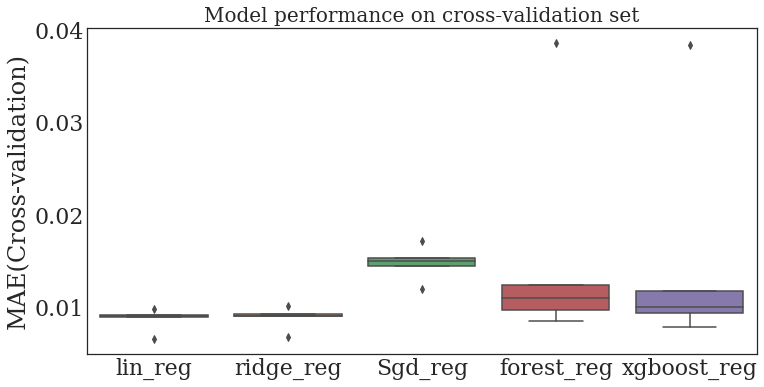

In [80]:
# Set figure size
plt.figure(figsize = (12,6))

# Display box plots
sns.boxplot(x = names, y = mae_scores)
plt.title('Model performance on cross-validation set', fontsize = 20)
plt.ylabel('MAE(Cross-validation)')

# C. Train Selected Model

Linear regression outperformed other model and will be selected for training

## C-1. Linear Regression

In [94]:
# Model training
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, logy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
# Model prediction on the training set
logy_train_pred = lin_reg.predict(X_train_scaled)

# Convert to original scale
y_train_pred = np.exp(logy_train_pred)
y_train = np.exp(logy_train)

In [109]:
print('Training set results:')
print('MAE:', mae(y_train, y_train_pred))
print('RMSE:', rmse(y_train, y_train_pred))
print('R^2:', r_squared(y_train, y_train_pred))

Training set results:
MAE: 0.007646621789248639
RMSE: 0.010347686899337188
R^2: 0.99583573672973


# D. Test Set Predictions

## D-1. Linear Regression

In [114]:
# Test prediction
logy_pred = Test_prediction(lin_reg, X_train_scaled, logy_train,X_test_scaled, logy_test)

# Convert to original scale
y_pred = np.exp(logy_pred)
y_test = np.exp(logy_test)

In [127]:
print('Test set results:')
print('MAE:', mae(y_pred, y_test))
print('RMSE:', rmse(y_pred, y_test))
print('R^2:', r_squared(y_pred, y_test))

Test set results:
MAE: 0.005676337110604372
RMSE: 0.007377195957052515
R^2: 0.988218945692398


In [150]:
test_df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, 'Residual': (y_pred-y_test)}, 
                      index = logy.iloc[test_size:].index)
test_df.head()

,Actual,Predicted,Residual
Date,,,
2012-11-25,0.77788,0.786199,0.008319
2012-12-02,0.77174,0.776487,0.004747
2012-12-09,0.76764,0.770695,0.003055
2012-12-16,0.76734,0.766676,-0.000664
2012-12-23,0.75710,0.767193,0.010093


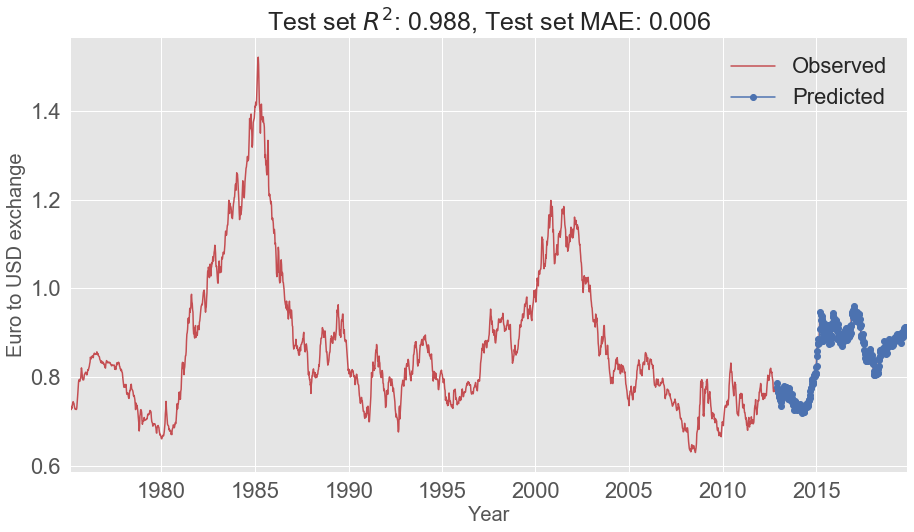

In [149]:
# Plot the result
plot_timeseries(ts.y,color = 'r', marker =None)
plot_timeseries(test_df.Predicted,color = 'b', marker = 'o')
plt.title('Test set $R^2$: %.3f, Test set MAE: %.3f'%(r_squared(y_pred, y_test), mae(y_pred, y_test)),
         fontsize = 25)
plt.legend(['Observed', 'Predicted'],loc = 'best')

## D-2. Diagnostic Plot on the Test Set

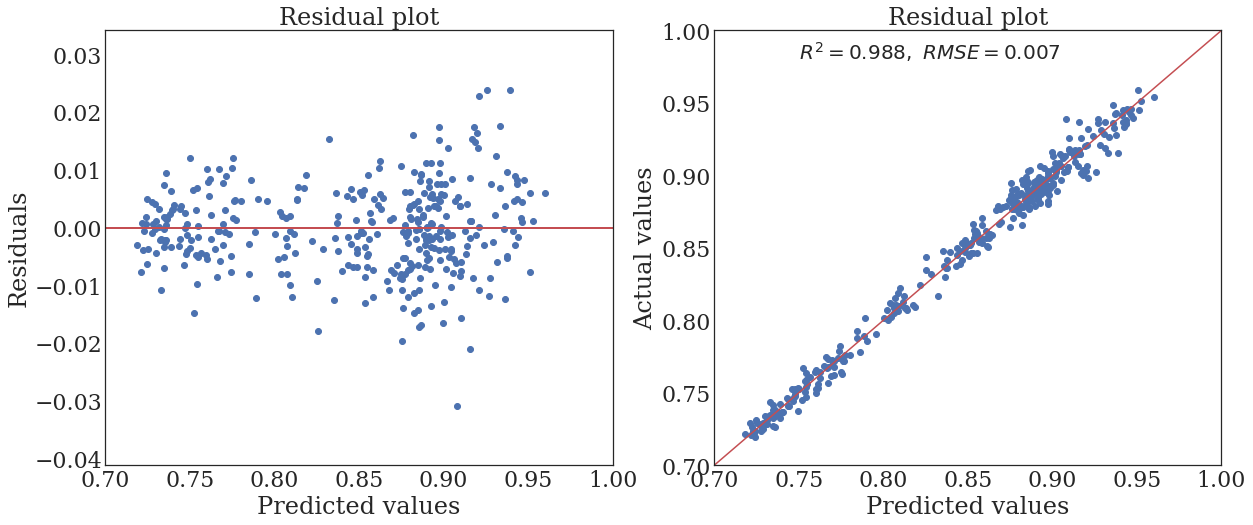

In [131]:
diagnostic_plot(y_pred, y_test)